If runnning code in colab, use Chrome

In [40]:
import copy
import logging
import random
from typing import Dict, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.metrics as sm
from sklearn.metrics import f1_score
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import models, transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image, make_grid
from tqdm import tqdm
from tqdm.notebook import tqdm
import torch.utils.tensorboard
from torch.utils.tensorboard import SummaryWriter

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_LAUNCH_BLOCKING"]="1"
torch.manual_seed(8675309)

In [41]:
#%pip install tensorboard
%reload_ext tensorboard
#%reload_ext tensorboard

#%rm -rf ./logs/ # clear tensorboard logs

# create instance of writer for tensorboard
writer = SummaryWriter('runs/mnist1')
%tensorboard --logdir {'/Users/sophiaxiao/FHAI/Fair-Health-AI/'}  --host localhost

In [42]:
train=torchvision.datasets.MNIST('data/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

test=torchvision.datasets.MNIST('data/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

In [43]:
class PrepareData:
    def __init__(self, train_set, test_set, prop_keep):
        """
        Arguments:
            train_set (torch dataset object)
            test_set (torch dataset object):
        Subsets data to select only desired classes, then imbalances training set, then refactors labels.
        Returns 4 float tensors
        """
        self.train_data, self.train_targets = self.prepare_imbalanced_dataset(train_set, prop_keep)
        self.test_data, self.test_targets = self.prepare_test_dataset(test_set)

    def prepare_test_dataset(self, dataset):
        data, targets = dataset.data, dataset.targets
        data, targets = self.subset_data(data, targets)
        targets = self.refactor_labels(targets)
        return data.float(), targets.float()

    def prepare_imbalanced_dataset(self, dataset, prop_keep):
        data, targets = dataset.data, dataset.targets
        data, targets = self.subset_data(data, targets)
        data, targets = self.imbalance_data(data, targets, prop_keep)
        targets = self.refactor_labels(targets)
        return data.float(), targets.float()

    def subset_data(self, data, targets):
        selection = torch.logical_or(targets == 2, targets == 7)
        data = data[selection]
        targets = targets[selection]
        return data, targets

    def imbalance_data(self, data, targets, prop_keep):
        sample_probs = {'2': (1 - prop_keep), '7': 0}
        idx_to_del = [i for i, label in enumerate(targets) if random.random() > sample_probs[str(label.item())]]
        data = data[idx_to_del]
        targets = targets[idx_to_del].type(torch.float)
        return data, targets

    def refactor_labels(self, targets):
        targets[targets == 2.] = 0
        targets[targets == 7.] = 1
        return targets


In [44]:
# Modify the data
data_preparer = PrepareData(train, test, 0.1)
train.data = data_preparer.train_data
train.targets = data_preparer.train_targets
test.data = data_preparer.test_data
test.targets = data_preparer.test_targets

In [45]:
# Define simple CNN to classify dataset examples
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 2)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [46]:
# configs
n_epochs = 20
batch_size_train = 128
batch_size_test = 500
learning_rate = 0.01
momentum = 0.5
log_interval = 10
class_labels = np.array([2,7])
torch.backends.cudnn.enabled = False
#device = 'cuda'

In [47]:
# Define train loader and test loader
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size_test, shuffle=True)

# Define loss function
loss_fn = nn.CrossEntropyLoss()


In [48]:
def vis(train_loss, test_accs, confusion_mtxes, labels, figsize=(7, 5)):
    cm = confusion_mtxes[np.argmax(test_accs)]
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%' % p
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'

    fig = plt.figure(figsize=figsize)

    plt.subplot(1, 3, 1)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.semilogy(train_loss, 'r')
    plt.ylabel('Log training loss')

    plt.subplot(1, 3, 2)
    plt.title('Test Accuracy (%)')
    plt.xlabel('Epoch')
    plt.ylabel('% accurate')
    plt.plot(test_accs, 'g')
    plt.grid(True)

    plt.subplot(1, 3, 3)
    sns.heatmap(cm, annot=annot, fmt='', cmap="Blues")
    plt.show()
    return fig

In [49]:
model = Net() #.to(device) # creating an instance of Net() and pushing it to GPU
optimizer = torch.optim.SGD(model.parameters(), learning_rate, momentum) # (optimizer args specified in configs)

train_loss = []
test_accs, confusion_mtxes = [], []
for epoch in range(1, n_epochs):
    model.train()
    logging.info(f"Starting epoch {epoch}:")
    pbar = tqdm(train_loader, position=0, leave=True)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data, target # since I'm using CPU, I do not push these tensors to device 
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        pbar.set_postfix(CE=loss.item())

    model.eval()
    correct = 0 # count correct predictions
    train_loss.append(loss.item())
    writer.add_scalar('Training loss',
                            loss.item(),
                            epoch)
    targets, preds = [], []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data, target # since I'm using CPU, I do not push these tensors to device 
            output = model(data)
            _, pred = torch.max(output,dim=1)
            correct += pred.eq(target.view_as(pred)).sum().item()

            targets += list(target.cpu().numpy())
            preds += list(pred.cpu().numpy())

    test_acc = 100. * correct / len(test_loader.dataset)
    confusion_mtx = sm.confusion_matrix(targets, preds)
    test_accs.append(test_acc)
    writer.add_scalar('Test Accuracy', test_acc, epoch)
    confusion_mtxes.append(confusion_mtx)
    print(epoch)
    print('\rBest test acc = %2.2f%%' % max(test_accs), end='', flush=True)



  0%|          | 0/54 [00:00<?, ?it/s]

1
Best test acc = 49.90%

  0%|          | 0/54 [00:00<?, ?it/s]

2
Best test acc = 49.90%

  0%|          | 0/54 [00:00<?, ?it/s]

3
Best test acc = 49.90%

  0%|          | 0/54 [00:00<?, ?it/s]

4
Best test acc = 49.90%

  0%|          | 0/54 [00:00<?, ?it/s]

5
Best test acc = 49.90%

  0%|          | 0/54 [00:00<?, ?it/s]

6
Best test acc = 49.90%

  0%|          | 0/54 [00:00<?, ?it/s]

7
Best test acc = 83.40%

  0%|          | 0/54 [00:00<?, ?it/s]

8
Best test acc = 88.45%

  0%|          | 0/54 [00:00<?, ?it/s]

9
Best test acc = 90.78%

  0%|          | 0/54 [00:00<?, ?it/s]

10
Best test acc = 90.78%

  0%|          | 0/54 [00:00<?, ?it/s]

11
Best test acc = 91.41%

  0%|          | 0/54 [00:00<?, ?it/s]

12
Best test acc = 92.14%

  0%|          | 0/54 [00:00<?, ?it/s]

13
Best test acc = 92.14%

  0%|          | 0/54 [00:00<?, ?it/s]

14
Best test acc = 92.14%

  0%|          | 0/54 [00:00<?, ?it/s]

15
Best test acc = 92.14%

  0%|          | 0/54 [00:00<?, ?it/s]

16
Best test acc = 92.14%

  0%|          | 0/54 [00:00<?, ?it/s]

17
Best test acc = 92.14%

  0%|          | 0/54 [00:00<?, ?it/s]

18
Best test acc = 92.14%

  0%|          | 0/54 [00:00<?, ?it/s]

19
Best test acc = 92.14%

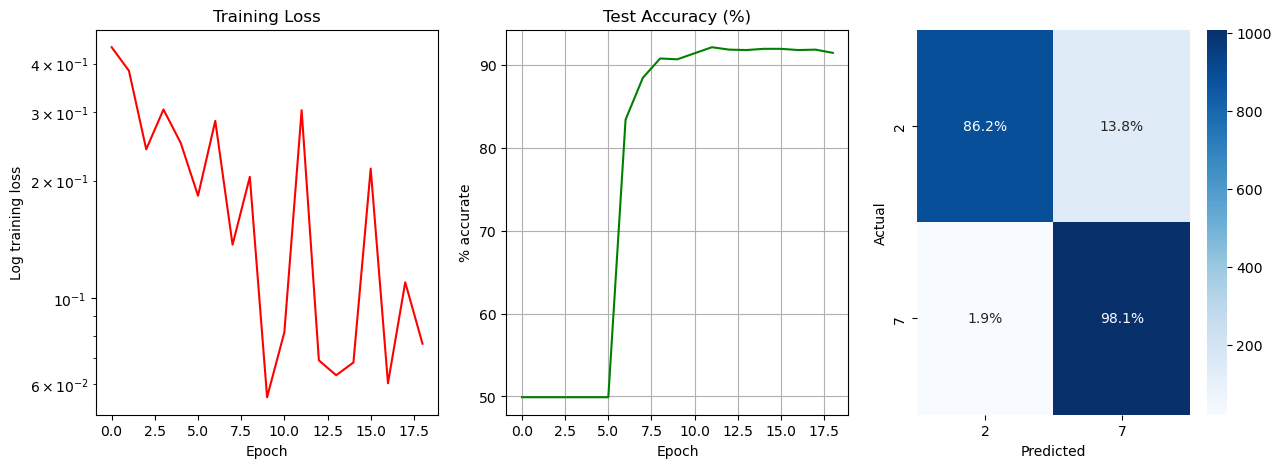

In [50]:
writer.add_figure('matplotlib', vis(train_loss, test_accs, confusion_mtxes, class_labels, figsize=(15, 5)))
writer.flush()
writer.close()
%tensorboard --logdir=runs

